# Introduction

<div dir="rtl">
<font size= "2">
در این پروژه شبکه عصبی را با استفاده از Keras و Tesnsorflow پیاده سازی می کنیم.  

از دیتاست UTKFace استفاده می کنیم و با استفاده از تصاویر چهره افراد، نژاد آن ها پیش بینی می کنیم. 
</font>
</div>


In [21]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div dir="rtl">
<font size= "2">
با استفاده از cp دیتا ست را بر روی ماشین مجازی می آوریم.

In [22]:
!cp "/content/drive/MyDrive/Colab Notebooks/UTKFace.tar.gz" .

extracting data:

In [23]:
!tar xvzf UTKFace.tar.gz

Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

In [24]:
from tensorflow.keras import *
from tensorflow.keras.utils import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import tensorboard
import os

# Phase 1)

### 1. read data

In [25]:
img_path = list()
Races = list()
path = "/content/UTKFace"

for img in os.listdir(path):
  temp = img.split('.')

  if len(temp[0].split('_')) == 4:
    img_path.append(os.path.join(path, img))
    Age, Gender, Race, Date = temp[0].split('_')
    Races.append(int(Race))
  else:
    continue 

### 2. total number of data

<div dir="rtl">
<font size= "2">
برای به دست آوردن تعداد داده های خوانده شده طول لیست داده های موجود در فایل را در نظر می گیریم.
</font>
</div>


In [26]:
len(os.listdir(path))

23708

### 2. number of classes

<div dir="rtl">
<font size= "2">
تعداد کلاس ها تعداد نژاد هایی است که در دیتاست وجود دارد و نژاد ها را در Races نگه داشته ایم  بنابر این با .unique می توان همه کلاس های موجود را نمایش داد.


In [27]:
np.unique(Races)

array([0, 1, 2, 3, 4])

### 3. plot number of data in each class_ class

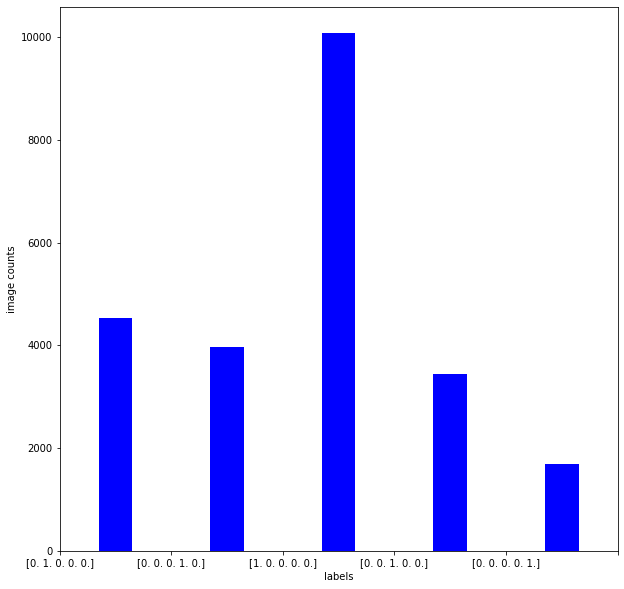

In [17]:
x_axis = np.arange(0, 6, 1)
plt.figure(figsize=(10, 10))
plt.hist(Races, x_axis, rwidth=0.3, color='b')
plt.xlabel("labels")
plt.ylabel("image counts")
plt.xticks(x_axis)
plt.show()

### 4. show images

In [28]:
import matplotlib.image as mpimg

def show_image(image_path, Race):
  classes_labels = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}
  img = mpimg.imread(image_path)
  plt.title(classes_labels[Race])
  plt.imshow(img)
  plt.show()

<div dir="rtl">
<font size= "1">
پیدا کردن ۵ تصویر با ۵ کلاس مختلف:
</font>
</div>


In [32]:
different_classes = {}
for i in range(len(img_path)):
    if Races[i] not in different_classes:
        different_classes[Races[i]] = img_path[i]
    if len(different_classes) >= 5:
        break
dictionary_items = different_classes.items()
different_classes = sorted(dictionary_items)

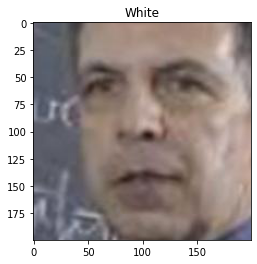

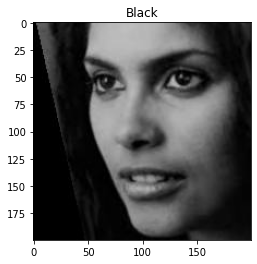

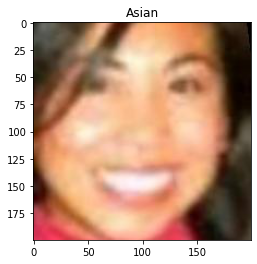

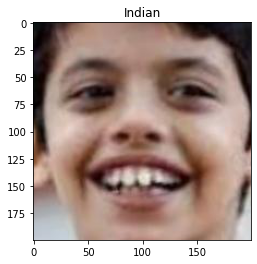

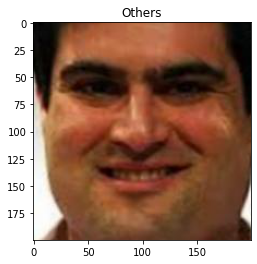

In [33]:
for image in(different_classes):
  show_image(image[1], image[0])

### 5. split dataset into test and train

<div dir="rtl">
<font size= "2">
به دلیل این که پیکسل ها بین صفر تا ۲۵۵ هستند آن را با اسکیل ۱/۲۵۵ اسکیل می کنیم. و با نسبت ۰.۳  جداسازی انجام می دهیم. یعنی ۳۰ درصد داده ها را برای تست و ۷۰ درصد را به عنوان داده آموزشی درنظر می گیریم.
</font>
</div>


In [34]:
dataGenerator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255.0,
    validation_split = 0.3
)

### 6. One Hot Encoding

<div dir="rtl">
<font size= "2">
برای هر کلاس یک label در نظر می گیریم و سپس  label  ها را برای هر داده به فرمت onehotآن ها تبدیل می کنیم.  
در onehot کلاس هر داده را به صورت باینری در نظر می گیریم که اگر داده در آن کلاس قرار داشته باشد یک و در غیر این صورت مقدار صفر می گیرد.  

در onehot encoding  وارزش هر کلاس یکسان است و ترتیب آن ها اهمیتی ندارد. به این معنی که اگر کلاس یک داده یک است و کلاس داده دیگر ۴ است، بیشتر بودن عدد ۴ نسبت به ۱ معنی خاصی نمی دهد و نباید در مدل سازی تاثیر بگذارد.

اگر از عدد های ترتیبی استفاده می کردیم ممکن بود تاثیر منفی در جواب نهایی داشته باشد.  

 در انتها در شبکه عصبی اگر ۵ نود برای خروجی شبکه در نظر بگیریم هر نود که عدد بزرگ تری داشته باشد را به عنوان کلاس پیش بینی شده برای آن داده در نظر می گیریم.
</font>
</div>


In [35]:
classes_labels = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}
Races = [str(to_categorical(i, len(classes_labels))) for i in Races]



---


# Phase 2)

### 1. create dataframe

<div dir="rtl">
<font size= "2">
با استفاده از تصاویر dataframe ای ایجاد می کنیم که مسیر هر تصویر و label مربوط به آن که به صورت  onehot  شده می باشد قرار دارد.
</font>
</div>


In [36]:
df = pd.DataFrame({
    'image' : img_path,
    'Race' : Races
})

In [122]:
df

,image,Race
0,/content/UTKFace/65_0_1_20170120223029947.jpg....,[0. 1. 0. 0. 0.]
1,/content/UTKFace/13_1_0_20170109214314841.jpg....,[1. 0. 0. 0. 0.]
2,/content/UTKFace/30_1_4_20170109135421119.jpg....,[0. 0. 0. 0. 1.]
3,/content/UTKFace/70_0_2_20170116192621613.jpg....,[0. 0. 1. 0. 0.]
4,/content/UTKFace/7_1_3_20161220222033539.jpg.c...,[0. 0. 0. 1. 0.]
...,...,...
23700,/content/UTKFace/26_0_1_20170117195838909.jpg....,[0. 1. 0. 0. 0.]
23701,/content/UTKFace/16_0_0_20170110232332618.jpg....,[1. 0. 0. 0. 0.]
23702,/content/UTKFace/1_0_1_20170110213647161.jpg.c...,[0. 1. 0. 0. 0.]
23703,/content/UTKFace/56_1_0_20170110122842545.jpg....,[1. 0. 0. 0. 0.]


In [37]:
TrainData = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = 'image',
    y_col = 'Race',
    target_size = (100, 100),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = 'categorical',
    subset = "training",
    shuffle = False
)

Found 16594 validated image filenames belonging to 5 classes.


In [38]:
TestData = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = 'image',
    y_col = 'Race',
    target_size = (100, 100),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = 'categorical',
    subset = "validation",
    shuffle = False
)

Found 7111 validated image filenames belonging to 5 classes.


In [125]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu")(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dense(5, activation="softmax")(output)

In [126]:
model = models.Model(inputs=input, outputs=output)

In [127]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss="categorical_crossentropy", metrics=['accuracy'])



---


### 2. layer parameters

<div dir="rtl">
<font size= "1">
داده ها را به ابعاد ۱۰۰ * ۱۰۰ تبدیل کرده ایم.
در لایه ورودی ۱۰۰۰۰ تا نود داریم و به هر لایه یک بایاس هم اضافه می شود بنابر این از هر یک از این ۱۰۰۱ نود به تعداد نورون های لایه بعد که در این جا ۱۰۲۴ می باشد، پارامتری را برای نگهداری وزن های شبکه درنظر می گیریم.  

بنابراین تعداد پارامتر ها به این صورت است:  
(تعداد نود های لایه + ۱) *تعداد نود های لایه بعدی 
</font>
</div>


layer 0 : zero parameters  
layer 1 : (10000+1) * 1024 = 10241024  
layer 2 : (1024+1) * 512 = 524800  
layer 3 : (512+1) * 5 = 2565 

In [128]:
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_62 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_63 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 2565      
Total params: 10,768,389
Trainable params: 10,768,389
Non-trainable params: 0
_________________________________________________________________




---

### 3. fit model

In [129]:
history = model.fit(TrainData, validation_data=TestData, epochs=10)

Epoch 1/10
519/519 [==============================] - 43s 83ms/step - loss: 1.2877 - accuracy: 0.4946 - val_loss: 1.1987 - val_accuracy: 0.5217
Epoch 2/10
519/519 [==============================] - 42s 82ms/step - loss: 1.1112 - accuracy: 0.5777 - val_loss: 1.1850 - val_accuracy: 0.5560
Epoch 3/10
519/519 [==============================] - 43s 82ms/step - loss: 1.0248 - accuracy: 0.6237 - val_loss: 0.9870 - val_accuracy: 0.6269
Epoch 4/10
519/519 [==============================] - 43s 82ms/step - loss: 0.9708 - accuracy: 0.6446 - val_loss: 1.2029 - val_accuracy: 0.5736
Epoch 5/10
519/519 [==============================] - 42s 82ms/step - loss: 0.9384 - accuracy: 0.6634 - val_loss: 0.9886 - val_accuracy: 0.6268
Epoch 6/10
519/519 [==============================] - 43s 83ms/step - loss: 0.9081 - accuracy: 0.6727 - val_loss: 0.8678 - val_accuracy: 0.6895
Epoch 7/10
519/519 [==============================] - 43s 83ms/step - loss: 0.8880 - accuracy: 0.6813 - val_loss: 0.9148 - val_accuracy:

In [130]:
model.evaluate(TestData)

223/223 [==============================] - 10s 44ms/step - loss: 0.9014 - accuracy: 0.6777


[0.9014086127281189, 0.6776824593544006]

In [131]:
true = TestData.classes
PredictedData = model.predict(TestData)
pred = list(np.argmax(PredictedData, axis=1))
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.38      0.06      0.10       553
           1       0.47      0.74      0.57      1165
           2       0.85      0.54      0.66      1064
           3       0.68      0.84      0.75      1334
           4       0.78      0.74      0.76      2995

    accuracy                           0.68      7111
   macro avg       0.63      0.59      0.57      7111
weighted avg       0.69      0.68      0.66      7111



In [132]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.287655,0.494576,1.198690,0.521727,0
1,1.111203,0.577739,1.184999,0.556040,1
2,1.024813,0.623659,0.986976,0.626916,2
3,0.970768,0.644631,1.202870,0.573618,3
4,0.938446,0.663372,0.988565,0.626775,4
5,0.908113,0.672713,0.867792,0.689495,5
6,0.887978,0.681331,0.914806,0.669245,6
7,0.865849,0.688020,0.852765,0.701448,7
8,0.845044,0.697843,0.922040,0.659542,8
9,0.823324,0.706159,0.901409,0.677682,9


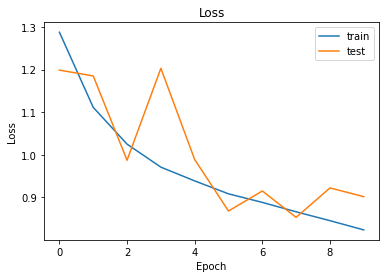

In [133]:
plt.figure()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist['epoch'], hist['loss'], label='train')
plt.plot(hist['epoch'], hist['val_loss'], label='test')
plt.legend()
plt.show()

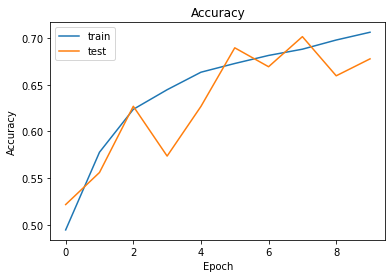

In [134]:
plt.figure()
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist['epoch'], hist['accuracy'], label='train')
plt.plot(hist['epoch'], hist['val_accuracy'], label='test')
plt.legend()
plt.show()



---


# Phase 3)

## Part 1. Optimizer

<div dir="rtl">
<font size= "2">
optimizer ها الگوریتم ها یا تابع هایی هستند که برای تغییر atrribute های شبکه عصبی مانند وزن ها و نرخ یادگیری و ... استفاده می شوند و هدف آن ها کاهش خطا می باشد. و برای حل مسئله بهینه سازی در کاهش خطا کاربرد دارند. 
 
مقدار پارامتر هایی که برای مدل اتخاب می کنیم بسیار بستگی به optimizer  ای دارد که برای آن در نظر می گیریم.
</font>
</div>




---


### momentum=0.5

<div dir="rtl">
<font size= "2">
تکانه شبکه عصبی تکنیکی برای افزایش سرعت و دقت در داده‌های آموزشی است.
Momentum در فیزیک ویژگی است که به سبب آن یک شی با وجود نیروی خارجی مخالف آن به حرکت خود ادامه می دهد.

Momentum در شبکه عصبی مفهومی مشابه دارد. هنگامی که تکانه را به آن اضافه کنیم مسیر انتخابی در برابر تغییر مقامت می کند.

شبکه عصبی non convex است درنتیجه ممکن است مینیمم محلی را به عنوان جواب خروجی دهد. با وجود اینکه مینیمم محلی ای که به ما می‌دهد همچنان خیلی نزدیک به global minimum است اما می‌توان این شرایط را با استفاده از تکانه شبکه عصبی بهتر کرد و مینیمم های محلی بهتر و نزدیک‌تر به جواب اصلی را پیدا کرد.

در این روش برای آپدیت کردن وزن ها علاوه بر گرادیان همان مرحله، با استفاده از پارامتر تکانه و گرادیان مرحله قبل وزن ها را آپدیت می کنیم.

</font>
</div>


<div dir="rtl">
<font size= "2">
در حالت عادی در SGD  وزن ها را به صورت زیر اپدیت می کنیم : $$ w= w - lr *g $$  

در گرادیان کاهشی مقادیر مشتق تابع خطا را به صورت دقیق  محاسبه نمی کنیم و فقط آن را برای هر batch تخمین می زنیم و میانگین آن را به دست می آوریم. در نتیجه آن ممکن است  همیشه حرکت  به سمت optimal direction نباشد و مسیر بهتری هم برای انتخاب وجود داشته باشد. 

ولی اگر بخواهیم از momentum استفاده کنیم اپیدت کردن وزن ها به صورت زیر تغییر می کند. 
</font>
</div>


<div dir="rtl">
<font size= "2">
اگر m  را میزان تجمعی گرادیان های کاهشی تا لحظه t در نظر بگیریم:

$$ m_t = \beta m_{t-1} + (1- \beta) \frac {\partial{L}} {\partial{w_t}} $$
$$ w_{t+1} = w_t + \alpha m_t$$
</font>
</div>


$$ velocity = momentum * velocity - lr * g \\
w = w + momentum * velocity - lr * g$$

<div dir="rtl">
<font size= "2">
فواید momentum:  

*   نوسانات و مشکل واریانس بالا برای پارامتر ها را بهبود می بخشد
*   نسبت به گرادیان کاهشی سریع تر عمل میکند

</font>
</div>


In [135]:
model_momentum_1 = models.Model(inputs=input, outputs=output)
model_momentum_1.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.5), loss="categorical_crossentropy", metrics=['accuracy'])

In [136]:
history_momentum_1 = model_momentum_1.fit(TrainData, validation_data=TestData, epochs=10)

Epoch 1/10
519/519 [==============================] - 46s 88ms/step - loss: 0.8742 - accuracy: 0.6843 - val_loss: 0.8522 - val_accuracy: 0.6899
Epoch 2/10
519/519 [==============================] - 46s 89ms/step - loss: 0.8381 - accuracy: 0.7006 - val_loss: 0.8911 - val_accuracy: 0.6714
Epoch 3/10
519/519 [==============================] - 45s 87ms/step - loss: 0.8171 - accuracy: 0.7071 - val_loss: 0.8617 - val_accuracy: 0.6872
Epoch 4/10
519/519 [==============================] - 46s 88ms/step - loss: 0.7978 - accuracy: 0.7114 - val_loss: 1.0135 - val_accuracy: 0.6383
Epoch 5/10
519/519 [==============================] - 46s 89ms/step - loss: 0.7792 - accuracy: 0.7192 - val_loss: 0.8105 - val_accuracy: 0.7076
Epoch 6/10
519/519 [==============================] - 45s 87ms/step - loss: 0.7652 - accuracy: 0.7286 - val_loss: 0.8673 - val_accuracy: 0.6927
Epoch 7/10
519/519 [==============================] - 46s 88ms/step - loss: 0.7562 - accuracy: 0.7315 - val_loss: 0.8017 - val_accuracy:

In [137]:
model_momentum_1.evaluate(TestData)

223/223 [==============================] - 9s 42ms/step - loss: 0.9276 - accuracy: 0.6635


[0.9275891184806824, 0.6634790897369385]

In [138]:
true_momentum_1 = TestData.classes
PredictedData_momentum_1 = model_momentum_1.predict(TestData)
pred_momentum_1 = list(np.argmax(PredictedData_momentum_1, axis=1))
print(classification_report(true_momentum_1, pred_momentum_1))

              precision    recall  f1-score   support

           0       0.47      0.04      0.08       553
           1       0.43      0.85      0.57      1165
           2       0.63      0.79      0.70      1064
           3       0.77      0.79      0.78      1334
           4       0.88      0.60      0.71      2995

    accuracy                           0.66      7111
   macro avg       0.64      0.62      0.57      7111
weighted avg       0.72      0.66      0.65      7111



In [139]:
hist_momentum_1 = pd.DataFrame(history_momentum_1.history)
hist_momentum_1['epoch'] = history_momentum_1.epoch

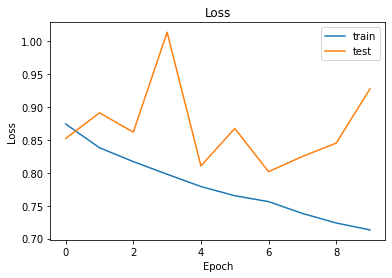

In [140]:
plt.figure()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_momentum_1['epoch'], hist_momentum_1['loss'], label='train')
plt.plot(hist_momentum_1['epoch'], hist_momentum_1['val_loss'], label='test')
plt.legend()
plt.show()

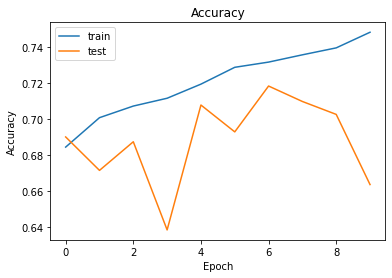

In [141]:
plt.figure()
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist_momentum_1['epoch'], hist_momentum_1['accuracy'], label='train')
plt.plot(hist_momentum_1['epoch'], hist_momentum_1['val_accuracy'], label='test')
plt.legend()
plt.show()



---


### momentum=0.9

<div dir="rtl">
<font size= "2">
با افزایش momentum  به ۰.۹ دقت برای f1_score افزایش پیدا کرده است. 

اگر مقدار مومنتوم را خیلی زیاد مثلا ۰.۹۸ درنظر بگیریم تاثیر منفی خواهد داشت به این دلیل که باعث ایجاد نوسان هایی می شود که مقدار آن ها به تدریج در طی یادگیری مدل افزایش میابد. و مدل ناپایدار می شود.
</font>
</div>


In [142]:
model_momentum_2 = models.Model(inputs=input, outputs=output)
model_momentum_2.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=['accuracy'])

In [143]:
history_momentum_2 = model_momentum_2.fit(TrainData, validation_data=TestData, epochs=10)

Epoch 1/10
519/519 [==============================] - 44s 85ms/step - loss: 1.1209 - accuracy: 0.5835 - val_loss: 1.1440 - val_accuracy: 0.5878
Epoch 2/10
519/519 [==============================] - 44s 86ms/step - loss: 1.1106 - accuracy: 0.5871 - val_loss: 1.0675 - val_accuracy: 0.5726
Epoch 3/10
519/519 [==============================] - 44s 85ms/step - loss: 1.0245 - accuracy: 0.6269 - val_loss: 1.0552 - val_accuracy: 0.6217
Epoch 4/10
519/519 [==============================] - 44s 84ms/step - loss: 0.9746 - accuracy: 0.6422 - val_loss: 0.9558 - val_accuracy: 0.6698
Epoch 5/10
519/519 [==============================] - 43s 84ms/step - loss: 0.9496 - accuracy: 0.6544 - val_loss: 0.9421 - val_accuracy: 0.6625
Epoch 6/10
519/519 [==============================] - 44s 84ms/step - loss: 0.9126 - accuracy: 0.6671 - val_loss: 0.9641 - val_accuracy: 0.6442
Epoch 7/10
519/519 [==============================] - 43s 83ms/step - loss: 0.8778 - accuracy: 0.6857 - val_loss: 0.9560 - val_accuracy:

In [144]:
true_momentum_2 = TestData.classes
PredictedData_momentum_2 = model_momentum_2.predict(TestData)
pred_momentum_2 = list(np.argmax(PredictedData_momentum_2, axis=1))
print(classification_report(true_momentum_2, pred_momentum_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       553
           1       0.61      0.56      0.58      1165
           2       0.59      0.82      0.68      1064
           3       0.70      0.83      0.76      1334
           4       0.77      0.77      0.77      2995

    accuracy                           0.69      7111
   macro avg       0.53      0.59      0.56      7111
weighted avg       0.64      0.69      0.66      7111



In [145]:
hist_momentum_2 = pd.DataFrame(history_momentum_2.history)
hist_momentum_2['epoch'] = history_momentum_2.epoch

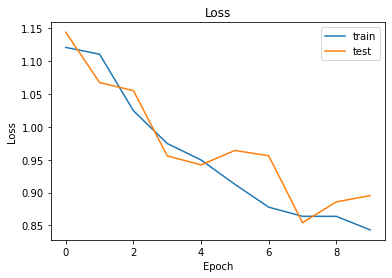

In [146]:
plt.figure()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_momentum_2['epoch'], hist_momentum_2['loss'], label='train')
plt.plot(hist_momentum_2['epoch'], hist_momentum_2['val_loss'], label='test')
plt.legend()
plt.show()

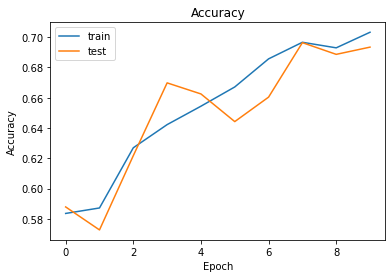

In [147]:
plt.figure()
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist_momentum_2['epoch'], hist_momentum_2['accuracy'], label='train')
plt.plot(hist_momentum_2['epoch'], hist_momentum_2['val_accuracy'], label='test')
plt.legend()
plt.show()



---

### Adam

<div dir="rtl">
<font size= "2">
SGD یا stochastic gradinet descent  یکی از انواع گرادیان های کاهشی می باشد که به جای این که اپدیت پارامتر ها را روی کل داده های انجام دهد آن را به بخش های کوچک تر تقسیم می کند و اپدیت ها را پس از بررسی هر  batch اعمال می کند. اگر  نرخ یادگیری کم باشد نتیجه ای مشابه با گرادیان کاهشی خواهد داشت.


</font>
</div>


<div dir="rtl">
<font size= "2">

Adaptive Moment Estimation یا Adam  الگوریتمی می باشد که ترکیبی از  SGD با momentum و RMS(root mean square propagation) می باشد.
در این الگوریتم نرخ یادگیری بهینه برای هر پارامتر به صورت جداگانه به دست می آید .
</font>
</div>


<div dir="rtl">
<font size= "2">
در این بخش نتایج نسبت به SGD بهبود یافته است. و دقت و F1 score افزایش یافته است.
</font>
</div>


In [148]:
model_Adam = models.Model(inputs=input, outputs=output)
model_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

In [149]:
history_Adam = model_Adam.fit(TrainData, validation_data=TestData, epochs=10)

Epoch 1/10
519/519 [==============================] - 53s 102ms/step - loss: 0.9048 - accuracy: 0.6815 - val_loss: 0.8648 - val_accuracy: 0.7061
Epoch 2/10
519/519 [==============================] - 50s 96ms/step - loss: 0.8512 - accuracy: 0.7018 - val_loss: 0.9753 - val_accuracy: 0.6605
Epoch 3/10
519/519 [==============================] - 47s 91ms/step - loss: 0.8449 - accuracy: 0.6986 - val_loss: 0.9384 - val_accuracy: 0.6631
Epoch 4/10
519/519 [==============================] - 47s 91ms/step - loss: 0.8425 - accuracy: 0.7045 - val_loss: 0.8460 - val_accuracy: 0.6962
Epoch 5/10
519/519 [==============================] - 48s 93ms/step - loss: 0.8206 - accuracy: 0.7119 - val_loss: 0.8879 - val_accuracy: 0.6847
Epoch 6/10
519/519 [==============================] - 48s 93ms/step - loss: 0.8096 - accuracy: 0.7154 - val_loss: 0.9153 - val_accuracy: 0.6584
Epoch 7/10
519/519 [==============================] - 48s 93ms/step - loss: 0.8124 - accuracy: 0.7140 - val_loss: 0.9126 - val_accuracy

In [150]:
true_Adam = TestData.classes
PredictedData_Adam = model_Adam.predict(TestData)
pred_Adam = list(np.argmax(PredictedData_Adam, axis=1))
print(classification_report(true_Adam, pred_Adam))

              precision    recall  f1-score   support

           0       0.43      0.08      0.13       553
           1       0.59      0.62      0.61      1165
           2       0.76      0.67      0.71      1064
           3       0.78      0.78      0.78      1334
           4       0.72      0.84      0.78      2995

    accuracy                           0.71      7111
   macro avg       0.66      0.60      0.60      7111
weighted avg       0.69      0.71      0.69      7111



In [151]:
hist_Adam= pd.DataFrame(history_Adam.history)
hist_Adam['epoch'] = history_Adam.epoch

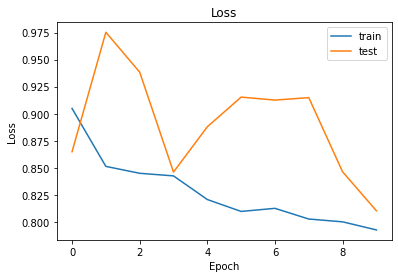

In [152]:
plt.figure()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_Adam['epoch'], hist_Adam['loss'], label='train')
plt.plot(hist_Adam['epoch'], hist_Adam['val_loss'], label='test')
plt.legend()
plt.show()

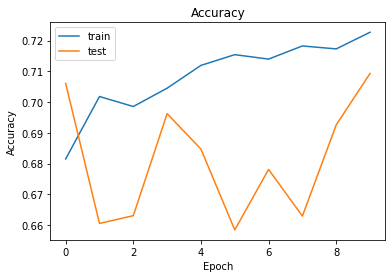

In [153]:
plt.figure()
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist_Adam['epoch'], hist_Adam['accuracy'], label='train')
plt.plot(hist_Adam['epoch'], hist_Adam['val_accuracy'], label='test')
plt.legend()
plt.show()

<div dir="rtl">
<font size= "2">
نوسانات برای داده های تست بسیار بیشتر از قبل می باشد ولی به نظر می رسد در نهایت عملکرد بهتری نسبت SGD دارد.
</font>
</div>




---


## Part 2. Epoch

<div dir="rtl">
<font size= "2">
epoch تعداد دفعاتی است که کل داده ها را بررسی می کنیم. یعنی یک forward  و یک back propagation  روی کل داده ها انجام شود.

 اگر فقط یک بار این کار را انجام دهیم مدل underfit می شود. و از طرفی اگر تعداد آن زیاد باشد مدل overfit می شود. بنابر این باید تعداد بهینه را برای آن پیدا کرد.  

هنگامی که overfit می شود یعنی خطا برای داده train بسیار کاهش میابد و نزدیک به صفر می شود ولی مدل برای داده جدید خوب کار نمی کند و دقت کم و خطای بالایی دارد.
</font>
</div>


<div dir="rtl">
<font size= "2">
راه حل:
باید پیچیدگی مدل را کم کرد و به طریقی از overfitting جلوگیری کرد. یکی از روش های آن استفاده از  regularization می باشد و یا ساده کردن شبکه یعنی کاهش تعداد نود های هر لایه و یا کم کردن تعداد لایه ها. که این روش پیشنهاد نمی شود زیرا ممکن است در نتیجه تاثیر منفی بگذارد و مدل به خوبی اموزش نبیند.
یعنی اگر داده ها پیچیده باشند و مدل ساده باشد، حتی اگر هم تعداد  epoch ها را بسیار زیاد کنیم نتیجه بهتری نخواهیم گرفت.
بهترین روش پیدا کردن بهینه ترین تعدا epoch رسم نمودار خطا می باشد.

بهترین مقدار برای epoch در جایی است که خطای test کم ترین مقدار خود می باشد.
</font>
</div>


In [154]:
model_epoch = models.Model(inputs=input, outputs=output)
model_epoch.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

In [155]:
history_epoch = model_epoch.fit(TrainData, validation_data=TestData, epochs=20)

Epoch 1/20
519/519 [==============================] - 51s 98ms/step - loss: 0.7932 - accuracy: 0.7210 - val_loss: 0.8372 - val_accuracy: 0.7031
Epoch 2/20
519/519 [==============================] - 52s 100ms/step - loss: 0.7765 - accuracy: 0.7282 - val_loss: 0.8521 - val_accuracy: 0.7072
Epoch 3/20
519/519 [==============================] - 53s 102ms/step - loss: 0.7773 - accuracy: 0.7262 - val_loss: 0.8463 - val_accuracy: 0.6940
Epoch 4/20
519/519 [==============================] - 53s 103ms/step - loss: 0.7763 - accuracy: 0.7258 - val_loss: 0.9713 - val_accuracy: 0.6674
Epoch 5/20
519/519 [==============================] - 52s 101ms/step - loss: 0.7609 - accuracy: 0.7307 - val_loss: 0.8350 - val_accuracy: 0.6988
Epoch 6/20
519/519 [==============================] - 52s 101ms/step - loss: 0.7562 - accuracy: 0.7313 - val_loss: 0.8163 - val_accuracy: 0.7134
Epoch 7/20
519/519 [==============================] - 52s 101ms/step - loss: 0.7600 - accuracy: 0.7328 - val_loss: 0.8669 - val_acc

In [156]:
true_epoch = TestData.classes
PredictedData_epoch = model_epoch.predict(TestData)
pred_epoch = list(np.argmax(PredictedData_epoch, axis=1))
print(classification_report(true_epoch, pred_epoch))

              precision    recall  f1-score   support

           0       0.41      0.07      0.12       553
           1       0.63      0.63      0.63      1165
           2       0.75      0.70      0.73      1064
           3       0.71      0.84      0.77      1334
           4       0.75      0.83      0.79      2995

    accuracy                           0.72      7111
   macro avg       0.65      0.62      0.61      7111
weighted avg       0.70      0.72      0.70      7111



In [157]:
hist_epoch = pd.DataFrame(history_epoch.history)
hist_epoch['epoch'] = history_epoch.epoch

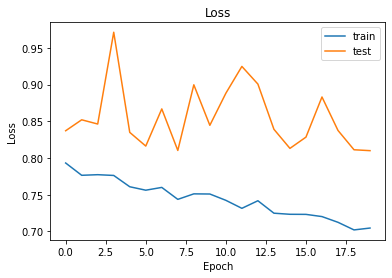

In [158]:
plt.figure()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_epoch['epoch'], hist_epoch['loss'], label='train')
plt.plot(hist_epoch['epoch'], hist_epoch['val_loss'], label='test')
plt.legend()
plt.show()

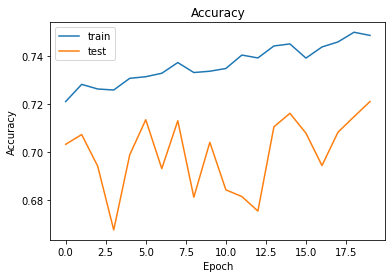

In [159]:
plt.figure()
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist_epoch['epoch'], hist_epoch['accuracy'], label='train')
plt.plot(hist_epoch['epoch'], hist_epoch['val_accuracy'], label='test')
plt.legend()
plt.show()

<div dir="rtl">
<font size= "2">
 در طول epoch ها خطا به تدریج کاهش و دقت افزایش می یابد. 
</font>
</div>




---

## Part 3. LossFunction

<div dir="rtl">
<font size= "2">
تابع MSE برای مسائل classification، non convex می باشد یعنی لزوما به بهینه ترین جواب همگرا نمی شود. به این دلیل که MSE برای مسائل ای که ورودی پیوسته دارند در واقع مسائل regression کاربرد دارند. در حالی که در مسائل classification در نهایت می خواهیم احتمال کلاس های مختلف را برای هر داده به دست آوریم که این احتمال بین صفر تا یک می باشد.

MSE برای مسائل Linear Regression به خوبی عمل می کند. 
فرضی که در MSE باید در نظر گرفت ای است که توزیع داده ها به صورت نرمال است در حالی که در داده های واقعی ممکن است به این صورت نباشد. بنابر این در هر  استفاده ای به این نکته باید توجه داشت.
</font>
</div>


In [160]:
model_MSE = models.Model(inputs=input, outputs=output)
model_MSE.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", metrics=['accuracy'])

In [161]:
history_MSE = model_MSE.fit(TrainData, validation_data=TestData, epochs=20)

Epoch 1/20
519/519 [==============================] - 49s 93ms/step - loss: 0.0713 - accuracy: 0.7453 - val_loss: 0.0814 - val_accuracy: 0.7100
Epoch 2/20
519/519 [==============================] - 49s 94ms/step - loss: 0.0726 - accuracy: 0.7439 - val_loss: 0.0829 - val_accuracy: 0.7113
Epoch 3/20
519/519 [==============================] - 49s 94ms/step - loss: 0.0702 - accuracy: 0.7535 - val_loss: 0.0989 - val_accuracy: 0.6583
Epoch 4/20
519/519 [==============================] - 49s 94ms/step - loss: 0.0733 - accuracy: 0.7416 - val_loss: 0.0842 - val_accuracy: 0.7019
Epoch 5/20
519/519 [==============================] - 48s 93ms/step - loss: 0.0706 - accuracy: 0.7495 - val_loss: 0.0862 - val_accuracy: 0.6993
Epoch 6/20
519/519 [==============================] - 49s 95ms/step - loss: 0.0714 - accuracy: 0.7494 - val_loss: 0.0799 - val_accuracy: 0.7171
Epoch 7/20
519/519 [==============================] - 49s 95ms/step - loss: 0.0705 - accuracy: 0.7521 - val_loss: 0.0867 - val_accuracy:

In [162]:
true_MSE = TestData.classes
PredictedData_MSE = model_MSE.predict(TestData)
pred_MSE = list(np.argmax(PredictedData_MSE, axis=1))
print(classification_report(true_MSE, pred_MSE))

              precision    recall  f1-score   support

           0       0.38      0.09      0.14       553
           1       0.56      0.71      0.62      1165
           2       0.65      0.80      0.71      1064
           3       0.77      0.80      0.79      1334
           4       0.80      0.75      0.77      2995

    accuracy                           0.71      7111
   macro avg       0.63      0.63      0.61      7111
weighted avg       0.70      0.71      0.69      7111



In [163]:
hist_MSE = pd.DataFrame(history_MSE.history)
hist_MSE['epoch'] = history_MSE.epoch

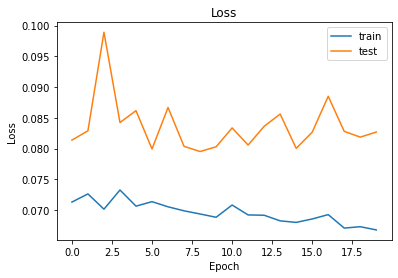

In [164]:
plt.figure()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_MSE['epoch'], hist_MSE['loss'], label='train')
plt.plot(hist_MSE['epoch'], hist_MSE['val_loss'], label='test')
plt.legend()
plt.show()

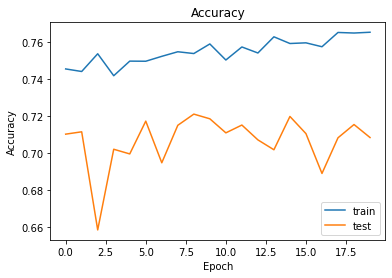

In [165]:
plt.figure()
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist_MSE['epoch'], hist_MSE['accuracy'], label='train')
plt.plot(hist_MSE['epoch'], hist_MSE['val_accuracy'], label='test')
plt.legend()
plt.show()



---


## Part 4. Regularization

### regularization

<div dir="rtl">
<font size= "2">
زمانی که مدل overfit  می شود برای بهینه کردن مدل از پایدارسازی استفاده می کنیم.
overfit شدن به این معنی است که مدل داده های نویز را هم در یادگیری مدل تاثیر می دهد. داده نویز، داده هایی هستند که نشان دهنده و نماینده خوبی از داده ها نیستند و معمولا به صورت رندوم هستند.

در هنگام overfit شدن خطای داده آموزشی بسیار کم است در حالی که خزطا برای داده تست زیاد است.
در هنگام  overfitting  مشکل واریانس بالا داریم .
</font>
</div>


<div dir="rtl">
<font size= "2">
پایدار سازی از پیچیدگی مدل کم می کند و از این طریق ریسک overfitting  را کاهش می دهد.

واریانس را کاهش می دهد بدون این که تاثیر چشم گیری در بایاس داشته باشد. و یا باعث شود که داده های مهم را از دست بدهیم.
</font>
</div>


<div dir="rtl">
<font size= "2">
نرم l2 ترم توان دو اندازه ضرایب را با ضریب $\lambda$  به تابع خطا اضافه می کند.  
هر چه $\lambda$ بزرگ تر باشد، به دلیل این که سعی در کاهش خطا داریم ضریب ها نزدیک تر به صفر می شوند و مدل ساده تر خواهد بود و واریانس کمتری خواهد داشت.
</font>
</div>


In [166]:
input_reg = layers.Input(shape = (100, 100, 1))

output_reg = layers.Flatten()(input_reg)
output_reg = layers.Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(l2=0.0001))(output_reg)
output_reg = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(l2=0.0001))(output_reg)
output_reg = layers.Dense(5, activation="softmax", kernel_regularizer=regularizers.l2(l2=0.0001))(output_reg)

In [167]:
model_reg = models.Model(inputs=input_reg, outputs=output_reg)
model_reg.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

In [168]:
history_reg = model_reg.fit(TrainData, validation_data=TestData, epochs=20)

Epoch 1/20
519/519 [==============================] - 70s 134ms/step - loss: 1.7004 - accuracy: 0.5205 - val_loss: 1.2579 - val_accuracy: 0.5735
Epoch 2/20
519/519 [==============================] - 69s 133ms/step - loss: 1.1833 - accuracy: 0.6102 - val_loss: 1.0923 - val_accuracy: 0.6496
Epoch 3/20
519/519 [==============================] - 69s 133ms/step - loss: 1.0836 - accuracy: 0.6355 - val_loss: 1.0932 - val_accuracy: 0.6261
Epoch 4/20
519/519 [==============================] - 70s 134ms/step - loss: 0.9957 - accuracy: 0.6703 - val_loss: 1.2039 - val_accuracy: 0.5842
Epoch 5/20
519/519 [==============================] - 69s 133ms/step - loss: 0.9670 - accuracy: 0.6731 - val_loss: 0.9295 - val_accuracy: 0.6892
Epoch 6/20
519/519 [==============================] - 70s 136ms/step - loss: 0.9409 - accuracy: 0.6795 - val_loss: 0.9308 - val_accuracy: 0.6826
Epoch 7/20
519/519 [==============================] - 69s 134ms/step - loss: 0.9053 - accuracy: 0.6925 - val_loss: 0.9824 - val_ac

In [169]:
true_reg = TestData.classes
PredictedData_reg = model_reg.predict(TestData)
pred_reg = list(np.argmax(PredictedData_reg, axis=1))
print(classification_report(true_reg, pred_reg))

              precision    recall  f1-score   support

           0       0.48      0.05      0.09       553
           1       0.57      0.65      0.61      1165
           2       0.87      0.46      0.60      1064
           3       0.72      0.83      0.77      1334
           4       0.70      0.85      0.77      2995

    accuracy                           0.69      7111
   macro avg       0.67      0.57      0.57      7111
weighted avg       0.69      0.69      0.67      7111



In [170]:
hist_reg = pd.DataFrame(history_reg.history)
hist_reg['epoch'] = history_reg.epoch

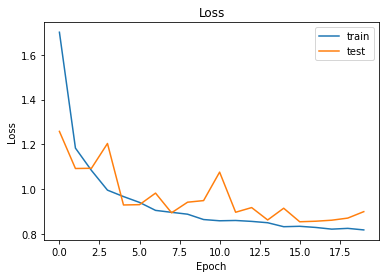

In [171]:
plt.figure()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_reg['epoch'], hist_reg['loss'], label='train')
plt.plot(hist_reg['epoch'], hist_reg['val_loss'], label='test')
plt.legend()
plt.show()

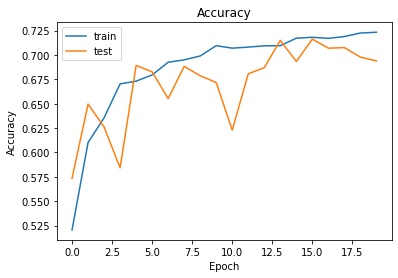

In [172]:
plt.figure()
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist_reg['epoch'], hist_reg['accuracy'], label='train')
plt.plot(hist_reg['epoch'], hist_reg['val_accuracy'], label='test')
plt.legend()
plt.show()

<div dir="rtl">
<font size= "2">

دقت مدل به میزان خیلی کمی کاهش یافته که این اتفاق می تواند دلیل های بسیار زیادی داشته باشد از جمله این که :


*   پیچیدگی های دیگر مدل 
*   تعداد داده هایی که برای آموزش و تست استفاده می کنیم
*   نوع توزیع داده ها 
*   مقدار دهی اولیه وزن ها
*   قرار گرفتن در مینیمم محلی(در SGD)
*   داده های نویز
*   ....
</font>
</div>


<div dir="rtl">
<font size= "2">
با این وجود مشاهده می شود که تابع خطا و دقت داده های آموزشی که برای epoch های مختلف رسم شده بسیار smooth تر شده است. 
احتمالا به این معنی است که مدل نسبت به داده های نویز حساسیت کمتری داشته است. 
</font>
</div>




---

### drop out

<div dir="rtl">
<font size= "2">
dropout یکی دیگر از روش هایی است که برای پایدارسازی و  جلوگیری از overfittingاستفاده می شود.

dropout  به معنای غیر فعال کردن نورون ها یا unit  های لایه‌ها است.
غیر فعال کردن به معنای این است که در زمان forward propagation و backward propagation  این نود ها را در نظر نمی‌گیریم و خروجی آن را صفر می دهیم.

به عنوان مثال برای هر نود می‌توانیم با احتمال p  آن را در شبکه نگهداریم و با احتمال 1-p آن را غیر فعال کنیم.

دلیل استفاده از این روش جلوگیری از overfit شدن مدل است.  در‌واقع به نوعی یک روش پایدار سازی می‌باشد که به مستقل شدن نورون ها از یکدیگر در یادگیری شبکه کمک می کند.

اگر H تعداد تود های لایه‌های داخلی باشد به تعداد 2H  حالت مختلف برای مدل خواهیم داشت.
</font>
</div>


<div dir="rtl">
<font size= "2">
تاثیرات drop out:

* باعث می شود که مدل  feature های robustتر را که در همگرا شدن مدل تاثیر بیشتری دارند را در مدل سازی استفاده کند.
* هنگام استفاده کردن از dropout به تعداد بیشتری epoch برای همگرا شدن مدل نیاز داریم.
</font>
</div>


In [39]:
input_dropout = layers.Input(shape = (100, 100, 1))

output_dropout = layers.Flatten()(input_dropout)
output_dropout = layers.Dense(1024, activation="relu")(output_dropout)
output_dropout = layers.Dropout(0.1)(output_dropout)
output_dropout = layers.Dense(512, activation="relu")(output_dropout)
output_dropout = layers.Dropout(0.1)(output_dropout)
output_dropout = layers.Dense(5, activation="softmax")(output_dropout)

In [40]:
model_dropout = models.Model(inputs=input_dropout, outputs=output_dropout)
model_dropout.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

In [41]:
history_dropout = model_dropout.fit(TrainData, validation_data=TestData, epochs=20)

Epoch 1/20
519/519 [==============================] - 67s 127ms/step - loss: 1.5827 - accuracy: 0.4622 - val_loss: 1.1746 - val_accuracy: 0.5262
Epoch 2/20
519/519 [==============================] - 67s 129ms/step - loss: 1.1423 - accuracy: 0.5475 - val_loss: 1.0382 - val_accuracy: 0.5961
Epoch 3/20
519/519 [==============================] - 68s 130ms/step - loss: 1.0781 - accuracy: 0.5911 - val_loss: 1.0040 - val_accuracy: 0.6456
Epoch 4/20
519/519 [==============================] - 67s 128ms/step - loss: 1.0569 - accuracy: 0.6032 - val_loss: 1.0132 - val_accuracy: 0.6342
Epoch 5/20
519/519 [==============================] - 66s 128ms/step - loss: 1.0272 - accuracy: 0.6152 - val_loss: 0.9529 - val_accuracy: 0.6593
Epoch 6/20
519/519 [==============================] - 65s 125ms/step - loss: 1.0141 - accuracy: 0.6246 - val_loss: 0.9876 - val_accuracy: 0.6380
Epoch 7/20
519/519 [==============================] - 65s 125ms/step - loss: 0.9960 - accuracy: 0.6322 - val_loss: 0.9662 - val_ac

In [42]:
true_dropout = TestData.classes
PredictedData_dropout = model_dropout.predict(TestData)
pred_dropout = list(np.argmax(PredictedData_dropout, axis=1))
print(classification_report(true_dropout, pred_dropout))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       525
           1       0.55      0.63      0.59      1209
           2       0.71      0.72      0.71      1023
           3       0.65      0.85      0.74      1370
           4       0.77      0.75      0.76      2984

    accuracy                           0.69      7111
   macro avg       0.54      0.59      0.56      7111
weighted avg       0.65      0.69      0.66      7111



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
hist_dropout = pd.DataFrame(history_dropout.history)
hist_dropout['epoch'] = history_dropout.epoch

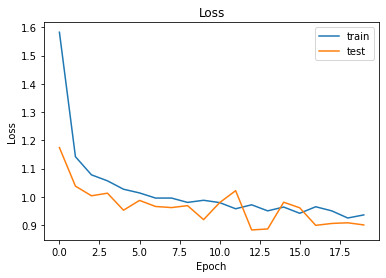

In [44]:
plt.figure()
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_dropout['epoch'], hist_dropout['loss'], label='train')
plt.plot(hist_dropout['epoch'], hist_dropout['val_loss'], label='test')
plt.legend()
plt.show()

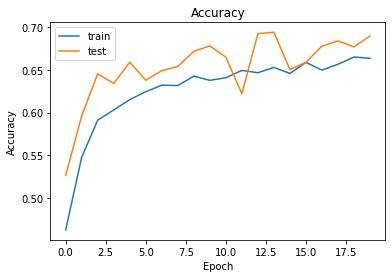

In [45]:
plt.figure()
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(hist_dropout['epoch'], hist_dropout['accuracy'], label='train')
plt.plot(hist_dropout['epoch'], hist_dropout['val_accuracy'], label='test')
plt.legend()
plt.show()



---

# Best Model

<div dir="rtl">
<font size= "2">
بهترین مدل Adam  با epoch=20 می باشد.
</font>
</div>


In [182]:
input_opt = layers.Input(shape = (100, 100, 1))

output_opt = layers.Flatten()(input_opt)
output_opt = layers.Dense(1024, activation="relu")(output_opt)
output_opt = layers.Dense(512, activation="relu")(output_opt)
output_opt = layers.Dense(5, activation="softmax")(output_opt)

In [183]:
model_opt = models.Model(inputs=input, outputs=output)
model_opt.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

In [184]:
history_opt = model_opt.fit(TrainData, validation_data=TestData, epochs=20)

Epoch 1/20
519/519 [==============================] - 48s 92ms/step - loss: 0.6744 - accuracy: 0.7685 - val_loss: 0.8365 - val_accuracy: 0.7173
Epoch 2/20
519/519 [==============================] - 48s 92ms/step - loss: 0.6665 - accuracy: 0.7734 - val_loss: 0.9030 - val_accuracy: 0.6885
Epoch 3/20
519/519 [==============================] - 48s 92ms/step - loss: 0.6684 - accuracy: 0.7672 - val_loss: 0.9065 - val_accuracy: 0.6999
Epoch 4/20
519/519 [==============================] - 48s 92ms/step - loss: 0.6646 - accuracy: 0.7730 - val_loss: 0.8240 - val_accuracy: 0.7185
Epoch 5/20
519/519 [==============================] - 48s 92ms/step - loss: 0.6507 - accuracy: 0.7744 - val_loss: 0.8598 - val_accuracy: 0.7154
Epoch 6/20
519/519 [==============================] - 48s 93ms/step - loss: 0.6496 - accuracy: 0.7749 - val_loss: 0.8988 - val_accuracy: 0.6922
Epoch 7/20
519/519 [==============================] - 48s 93ms/step - loss: 0.6452 - accuracy: 0.7767 - val_loss: 0.8534 - val_accuracy:

In [205]:
true_opt = TestData.classes
PredictedData_opt = model_opt.predict(TestData)
pred_opt = list(np.argmax(PredictedData_opt, axis=1))
print(classification_report(true_opt, pred_opt))

              precision    recall  f1-score   support

           0       0.43      0.05      0.09       553
           1       0.57      0.71      0.63      1165
           2       0.75      0.70      0.72      1064
           3       0.71      0.82      0.76      1334
           4       0.77      0.79      0.78      2995

    accuracy                           0.71      7111
   macro avg       0.65      0.61      0.60      7111
weighted avg       0.70      0.71      0.69      7111



In [420]:
x, y = TestData.next()

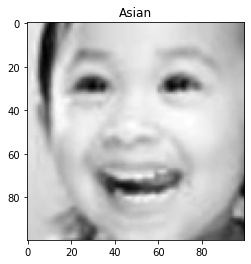

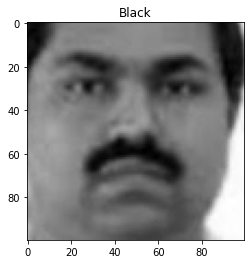

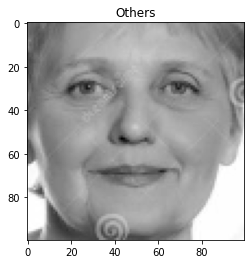

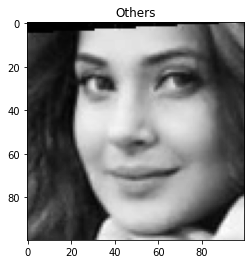

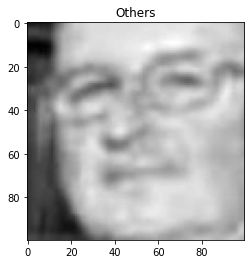

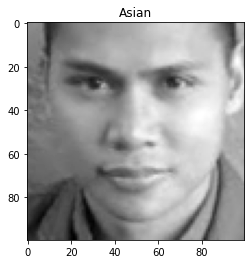

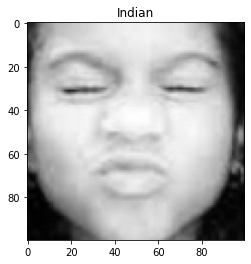

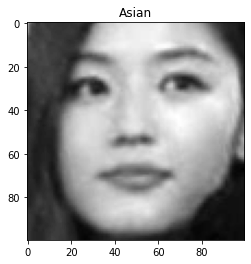

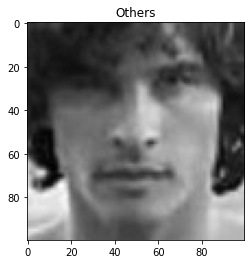

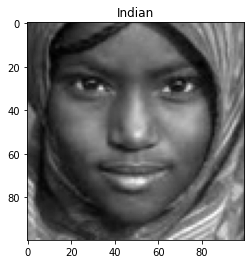

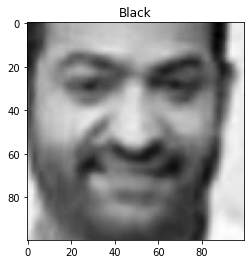

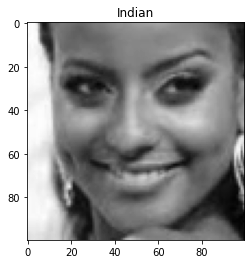

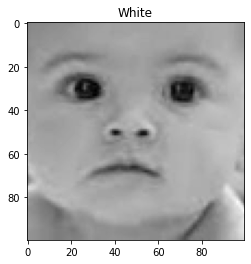

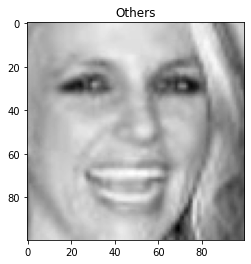

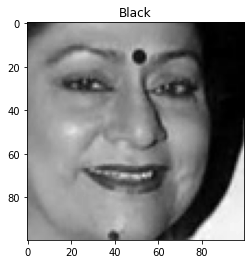

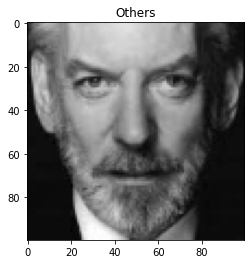

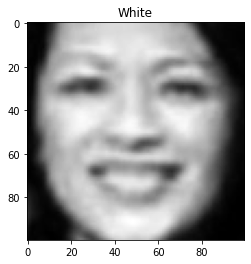

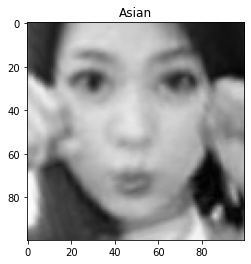

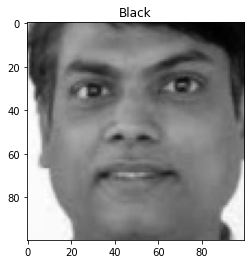

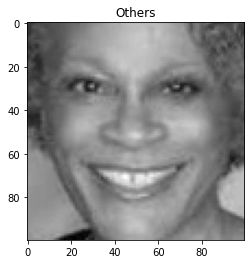

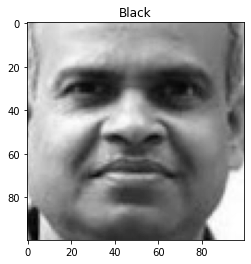

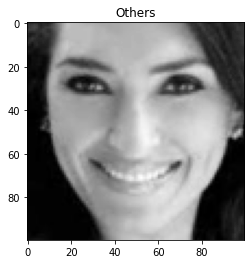

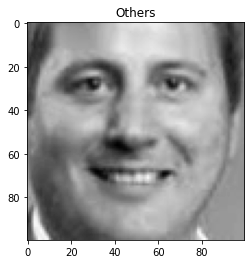

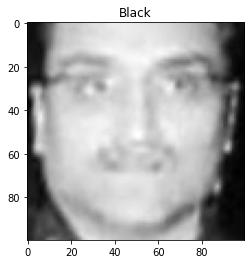

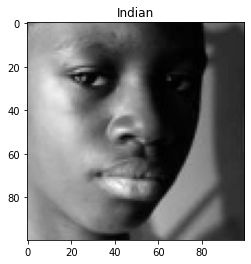

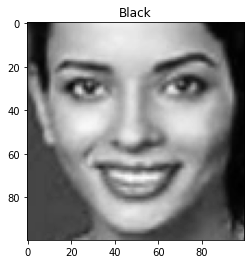

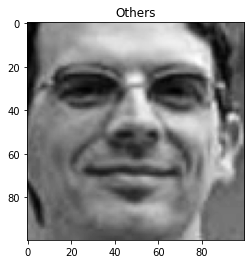

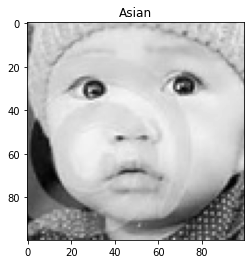

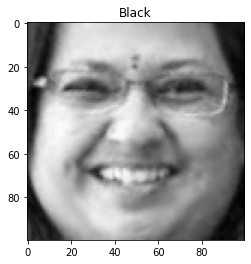

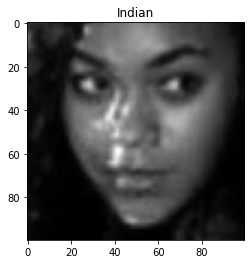

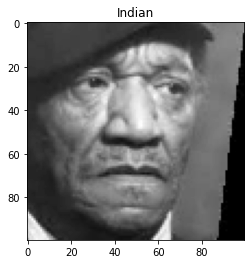

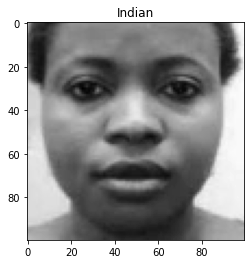

In [421]:
classes_labels = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}
label = np.argmax(y, axis=1)

for i in range(32):
  plt.title(classes_labels[label[i]])
  plt.imshow(x[i].squeeze(), cmap='gray')
  plt.show()



---


# Phase 4)

In [200]:
input_enc = layers.Input(shape = (100, 100, 1))

output_enc = layers.Flatten()(input_enc)
output_enc = layers.Dense(1024, activation="relu")(output_enc)
output_enc = layers.Dense(512, activation="relu")(output_enc)
output_enc = layers.Dense(256, activation="relu")(output_enc)
output_encoded = layers.Dense(2, activation="relu")(output_enc)
output_decoded = layers.Dense(5, activation="softmax")(output_enc)

In [202]:
autoencoder = models.Model(inputs=input_enc, outputs=output_decoded)

encoder = models.Model(inputs=input_enc, outputs=output_encoded)

encoded_input = layers.Input(shape=(2,))
decoder_layer = autoencoder.layers[-1]
decoder = models.Model(encoded_input, decoder_layer(encoded_input))

In [203]:
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])

In [204]:
history_enc = autoencoder.fit(TrainData, validation_data=TestData, epochs=3)

Epoch 1/3
519/519 [==============================] - 50s 96ms/step - loss: 1.3808 - accuracy: 0.5177 - val_loss: 1.1753 - val_accuracy: 0.5549
Epoch 2/3
519/519 [==============================] - 49s 95ms/step - loss: 1.0477 - accuracy: 0.6171 - val_loss: 1.0619 - val_accuracy: 0.6110
Epoch 3/3
519/519 [==============================] - 48s 93ms/step - loss: 0.9729 - accuracy: 0.6518 - val_loss: 0.9139 - val_accuracy: 0.6718




---

# Conclusion

<div dir="rtl">
<font size= "2">
پیدا کردن هایپر پارامتر های مسئله تاثبر بسیاری در مدل سازی دارند. یکی از بهترین روش های پیدا کردن این مقادیر رسم تاثیر تغییرات آن ها را تابع خطا و دقت می باشد. با توجه به نمودار های آن به راحتی می توان مقدار بهینه را پیدا کرد. در مدل سازی شبکه عصبی باید به overfitting توجه کرد در غیر این صورت مدل کارامد نخواهد بود.
باید با توجه به داده ها و نوع ویژگی ها و تعداد نمونه های آموزشی مدل را آموزش داد و برای پیش بینی داده های جدید از آن استفاده کرد. 
</font>
</div>


<div dir="rtl">
<font size= "2">
در مدل سازی شبکه عصبی با توجه کردن به بسیاری از پارامتر ها از جمله تعداد نورون های هر لایه، تعداد لایه ها پنهان، optimizer مورد استفاده، تعداد epochها، loss function و ترم پایدارسازی، می توان مدل را به تدریج بهبود داد که نسبت به داده های جدید عملکرد خوبی داشته باشد.
</font>
</div>


In [3]:
import os
os.system('jupyter nbconvert --to html AI_CA5_P2_810896059.ipynb')

0